### Midi File Loading - **Don't need to run, see loading blocks below**

In [368]:
from mido import MidiFile
import os
from tqdm import tqdm

#takes in a directory and loads all the midi files in it
def load_midis(directory):
  full_dir = 'Data/' + directory
  #assumes all files in the dir are midis
  m_list = []
  #load and turn each midi into a midi object
  for f in tqdm(os.listdir(full_dir), position = 0, leave = True):
    m_list.append(MidiFile(full_dir + '/' + f))
  return m_list

In [369]:
import re

#which folders to use?
possible_dirs = os.listdir('Data/')
composer_names = []
composer_dirs = []

for d in possible_dirs:
  u = re.match('(\w+)Keyboard', d)
  if u and len(os.listdir('Data/' + d)) > 0:
    composer_names.append(u.groups(0)[0].lower())
    composer_dirs.append(d)
composer_dirs

['ChopinKeyboard',
 'SchumannKeyboard',
 'BeethovenKeyboard',
 'BachKeyboard',
 'MozartKeyboard',
 'CzernyKeyboard',
 'SatieKeyboard',
 'SchubertKeyboard',
 'RachmaninoffKeyboard']

In [370]:
composer_midis = []

for directory in composer_dirs:
  composer_midis.append(load_midis(directory))

100%|██████████| 10/10 [00:00<00:00, 25.33it/s]


### Conversion to DF - **Don't need to run**

In [371]:
import numpy as np
import pandas as pd
import time

def extract_tracks(mido_file):
  # extract all tracks and messages and the filename
  msg_list = []
  #meta currently unused, but can be used to extract key information
  meta = []
  for track in mido_file.tracks:
    msgs = [msg for msg in track if not msg.is_meta]
    meta = [msg for msg in track if msg.is_meta]
    if msgs:
      msg_list.append((mido_file.filename, msgs))
  #returns a dictionary of filenames:msg_list
  return msg_list

#takes in list of list of messages
#returns a list of dataframes containing each track's info
def extract_dfs(track_pairs, composer_name):
  #this is dumb but im lazy to change it
  mido_df = pd.DataFrame(track_pairs, columns = ['filename','track'])
  mido_df.track = [pd.Series(t).astype(str) for t in mido_df.track]
  def track_to_df(track):
    split_track = track.str.split()
    n_cols = len(split_track[0]) - 1
    split_track = split_track[split_track.apply(lambda l: l[0] == 'note_on' or l[0] == 'note_off')]
    val_cols = split_track.apply(lambda l: l[1:])
    track_df = pd.DataFrame(val_cols.to_list())
    cleaned = track_df.apply(lambda c: c.str.split('=')).applymap(lambda r: int(r[1]))
    try:
      cleaned.columns = ['channel', 'note', 'velocity', 'time']
    except:
      return None
    cleaned['note_type'] = split_track.apply(lambda l: l[0]).values
    cleaned['cumtime'] = cleaned['time'].cumsum()
    cleaned = cleaned[cleaned['note'] != 0]
    return cleaned
  mido_df['dataframes'] = mido_df.track.apply(track_to_df)
  mido_df = mido_df[mido_df.track != None]
  #returns filename: dataframe pair
  return mido_df['filename'][0], pd.concat(mido_df.dataframes.values).sort_values(by = 'cumtime'), composer_name

In [372]:
tic = time.time()
composer_pieces = pd.concat([pd.DataFrame([extract_dfs(extract_tracks(m), composer_names[i]) for m in tqdm(composer_midis[i], leave = True, position = 0)]) for i in range(len(composer_midis))])
toc = time.time()
print('Time Elapsed: ',toc-tic,'s')

100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Time Elapsed:  27.92367720603943 s


In [373]:
#to convert to notes:
#determine if it specifies note_on note_off or just note_on
#split each dataset by track (channel) and there should only really be 2
#for note_on/note_off types, simply calculate the length of each note_on by finding the diff in cumtime of the note_off
#for note_on types, find the next note and subtract the cumtimes to get the length

def noteon_only(piece):
  return len(piece['note_type'].unique()) == 1

def freq_to_note(piece):
  noteons = noteon_only(piece)
  p = piece.reset_index().drop(columns = 'index')
  h = p.groupby('note')
  #within each group, split into note_ons and note_offs then subtract to obtain lengths
  #preserve the note_on index for proper merging into the original dataframe
  def get_lengths(group):
    if not noteons:
      gon, goff = group[group.note_type == 'note_on'], group[group.note_type == 'note_off']
    else:
      gon = group[group.velocity != 0]
      goff = group[group.velocity == 0]
    if len(gon) != len(goff):
      #fix midi's messy action recording by pairing ons with offs that are above each on
      #basically default to slow process
      lengths = []
      used_offs = set()
      for i, g in gon.iterrows():
        above = goff[(goff.cumtime > g.cumtime) & (~goff.index.isin(used_offs))]
        used_offs.add(above.index[0])
        lengths.append(above.iloc[0].cumtime - g.cumtime)
      return pd.Series(lengths, index = gon.index)
    return goff.cumtime.values - gon.cumtime
  f = h.apply(get_lengths)
  lengths = pd.Series(f.values, f.index.get_level_values(1))
  p['length'] = lengths
  p = p[~p['length'].isnull()]
  return p

def freq_to_notes(piece_list):
  conv_list = []
  for piece in tqdm(piece_list, leave = True, position = 0):
    conv_list.append(freq_to_note(piece))
  return conv_list

In [374]:
composer_pieces['key_presses'] = freq_to_notes(composer_pieces[1])

100%|██████████| 389/389 [00:27<00:00, 14.13it/s]


In [397]:
def merge_times(chunk):
    possible_notes = np.arange(15,116)
    new_cols = {}
    for n in possible_notes:
        new_cols[n] = (chunk.note == n).astype(int)
    new_chunk = pd.concat([pd.DataFrame(new_cols),chunk],axis=1).drop(columns='note')
    #merge based on cumtime
    agg_dict = {}
    for col in new_chunk.columns[:101]:
        agg_dict[col] = 'sum'
    for col in new_chunk.columns[101:]:
        agg_dict[col] = 'first'
    return new_chunk.groupby('cumtime').agg(agg_dict)

merged = []
for ch in tqdm(composer_pieces.key_presses, leave = True, position = 0):
    merged.append(merge_times(ch))
composer_pieces['merged'] = merged

100%|██████████| 389/389 [00:30<00:00, 12.61it/s]


### Start here, load in the dfs

In [398]:
import pandas as pd
import numpy as np
from joblib import dump, load

#start here
#only run this dump stuff if you ran the previous cells to update how the dataframes are constructed
#dump(composer_pieces, 'Data/composer_dfs')
composer_dfs = load('Data/composer_dfs')

In [354]:
composer_dfs

,0,1,2,key_presses
0,Data/ChopinKeyboard/Chop-28-8.mid,channel note velocity time note_type ...,chopin,channel note velocity time note_type ...
1,Data/ChopinKeyboard/Chop-28-23.mid,channel note velocity time note_type ...,chopin,channel note velocity time note_type ...
2,Data/ChopinKeyboard/Chop-28-22.mid,channel note velocity time note_type ...,chopin,channel note velocity time note_type ...
3,Data/ChopinKeyboard/10-02-i.mid,channel note velocity time note_type ...,chopin,channel note velocity time note_type ...
4,Data/ChopinKeyboard/Chop-28-9.mid,channel note velocity time note_type ...,chopin,channel note velocity time note_type ...
...,...,...,...,...
5,Data/RachmaninoffKeyboard/rach-prelude23-02.mid,channel note velocity time note_type ...,rachmaninoff,channel note velocity time note_type ...
6,Data/RachmaninoffKeyboard/rach-prelude23-01.mid,channel note velocity time note_type ...,rachmaninoff,channel note velocity time note_type ...
7,Data/RachmaninoffKeyboard/rach-prelude-op3-no2...,channel note velocity time note_type ...,rachmaninoff,channel note velocity time note_type ...
8,Data/RachmaninoffKeyboard/rach-prelude23-09.mid,channel note velocity time note_type ...,rachmaninoff,channel note velocity time note_type ...


100%|██████████| 900/900 [00:11<00:00, 80.66it/s]


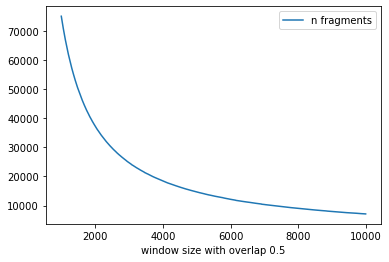

In [353]:
import seaborn as sns
from matplotlib import pyplot as plt

#how many fragments can we generate, essentially how large is our dataset
#sliding a time window over our data (size = n)

def n_fragments(pieces, n = 5000, ov = 0.5):
    piece_lengths = np.array(pieces.apply(lambda p: p.cumtime.max()))
    if ov > 0:
        return (piece_lengths // n / ov).sum()
    else:
        return (piece_lengths // n).sum()

possible_range = np.arange(1000,10000,10)
frags = []
for g in tqdm(possible_range, position = 0, leave = True):
    s = 0
    s += n_fragments(composer_dfs.key_presses, g)
    frags.append(s)
ax = sns.lineplot(x = possible_range, y = frags, label = 'n fragments')
_=plt.xlabel('window size with overlap 0.5')

In [367]:
#break up pieces into chunks

#takes in a whole piece and spits out a dataframe of chunks
#using a sliding time window 
#optional overlap argument
def piece_to_chunk(piece, n = 5000, ov = 0, min_notes = 10):
    chunks = []
    piece_data = piece['key_presses'].copy()
    i = 1
    sliced = 0
    while len(piece_data) > min_notes:
        #only uses chunks with at least min_notes
        below = piece_data[piece_data.cumtime <= sliced + n]
        if len(below) >= min_notes:
            chunks.append([piece[2], piece[0], below])
        if ov > 0:
            sliced += n*(1 - ov)
        else:
            sliced += n
        piece_data = piece_data[piece_data.cumtime > sliced]
    return pd.DataFrame(chunks)

from joblib import Parallel, delayed

#takes in a dataframe of filename,data,key_presses,composer_name
#returns the expanded version of chunks
def chunk(all_pieces, n = 5000, ov = 0, min_notes = 10):
    chunks = []
    for i, c in tqdm(all_pieces.iterrows(),leave=True,position=0):
        chunks.append(piece_to_chunk(c,n,ov,min_notes))
    return pd.concat(chunks)

In [325]:
#create dataframes of chunks for each composer
composer_df = chunk(composer_dfs, n = 5000).reset_index(drop=True)
composer_df

47it [00:00, 57.57it/s]
34it [00:00, 115.50it/s]
42it [00:01, 22.81it/s]
125it [00:01, 92.76it/s]
34it [00:00, 43.93it/s]
31it [00:00, 226.32it/s]
16it [00:00, 92.40it/s]
43it [22:57, 32.03s/it]2487 [00:13<00:01, 4868.64it/s]
50it [00:06,  7.78it/s]
10it [00:00, 61.04it/s]


,filename,data,Composer
0,Data/ChopinKeyboard/Chop-28-8.mid,channel note velocity time note_type ...,chopin
1,Data/ChopinKeyboard/Chop-28-8.mid,channel note velocity time note_type ...,chopin
2,Data/ChopinKeyboard/Chop-28-8.mid,channel note velocity time note_type ...,chopin
3,Data/ChopinKeyboard/Chop-28-8.mid,channel note velocity time note_type ...,chopin
4,Data/ChopinKeyboard/Chop-28-8.mid,channel note velocity time note_type ...,chopin
...,...,...,...
7615,Data/RachmaninoffKeyboard/rach-prelude23-08.mid,channel note velocity time note_type ...,rachmaninoff
7616,Data/RachmaninoffKeyboard/rach-prelude23-08.mid,channel note velocity time note_type ...,rachmaninoff
7617,Data/RachmaninoffKeyboard/rach-prelude23-08.mid,channel note velocity time note_type ...,rachmaninoff
7618,Data/RachmaninoffKeyboard/rach-prelude23-08.mid,channel note velocity time note_type ...,rachmaninoff


### Feature Engineering

In [326]:
def bag_of_words(chunk):
    note_values = np.arange(17,109)
    bag = chunk['note'].value_counts()
    other = pd.Series(0*note_values, index = note_values)
    other[bag.index] = bag
    return other.values

def note_range(chunk):
    return chunk['note'].max() - chunk['note'].min()

#returns 2 args
def jump(chunk):
    if len(chunk) <= 1:
        return 0
    if len(chunk['channel'].unique()) <= 1:
        note_diffs = chunk['note'].diff()[1:]
    else:
        note_diffs = chunk[['channel','note']].groupby('channel').diff().dropna()
    note_diffs = note_diffs.values
    return np.abs(note_diffs).mean(), note_diffs.mean()

#2 args
def length(chunk):
    return chunk.length.mean(), chunk.length.median()

#how many notes are played on the same time out of total notes?
def chord_frequency(chunk):
  cu = chunk.groupby('cumtime').count()['channel']
  return cu[cu > 1].sum() / cu.sum()

#how wide chords are in the chunk
def chord_spread_mean(chunk):
    cu = chunk[['cumtime','note']].groupby('cumtime')
    cu = cu.max() - cu.min()
    pos = cu.note > 0
    if (pos > 0).any():
        return cu[pos].note.mean()
    else:
        return 0

bag_cols = str(list(range(17,109)))[1:-1].replace(',','')
#each feature generates a dataframe
feat = {bag_cols:bag_of_words,
        'range':note_range,  
        'abs_avg_jump avg_jump':jump,
        'mean_length median_length':length,
        'chord_frequency':chord_frequency,
        'chord_spread':chord_spread_mean}

#keyfunc is a [key, function] list
def apply_feature_func(keyfunc, piece_list):
    columns = keyfunc[0].split(' ')
    values = Parallel(n_jobs=-1)(delayed(keyfunc[1])(d) for d in tqdm(piece_list, position = 0, leave = True))
    return pd.DataFrame(values, columns = columns)
    
#features is a suite of name:function that create features from chunks
def pieces_to_features(piece_df, features = feat):
    df = pd.concat([apply_feature_func([k,features[k]], piece_df['data']) for k in features], axis=1)
    return piece_df.join(df)

In [327]:
all_data = pieces_to_features(composer_df)
all_data.drop(columns='data',inplace=True)
all_data.head(5)

100%|██████████| 7620/7620 [00:05<00:00, 1326.81it/s]


,filename,Composer,17,18,19,20,21,22,23,24,...,106,107,108,range,abs_avg_jump,avg_jump,mean_length,median_length,chord_frequency,chord_spread
0,Data/ChopinKeyboard/Chop-28-8.mid,chopin,0,0,0,0,0,0,0,0,...,0,0,0,50,7.410405,0.000000,80.274286,64.0,0.400000,15.200000
1,Data/ChopinKeyboard/Chop-28-8.mid,chopin,0,0,0,0,0,0,0,0,...,0,0,0,48,7.232558,-0.046512,79.264368,64.0,0.402299,12.171429
2,Data/ChopinKeyboard/Chop-28-8.mid,chopin,0,0,0,0,0,0,0,0,...,0,0,0,49,7.614035,-0.152047,79.167630,64.0,0.404624,19.971429
3,Data/ChopinKeyboard/Chop-28-8.mid,chopin,0,0,0,0,0,0,0,0,...,0,0,0,51,7.988372,-0.093023,78.528736,64.0,0.390805,18.588235
4,Data/ChopinKeyboard/Chop-28-8.mid,chopin,0,0,0,0,0,0,0,0,...,0,0,0,41,7.818713,0.064327,79.352601,64.0,0.404624,10.911765


In [328]:
#optional-add time period as a possible response variable
composer_eras = {'bach':'Baroque',
                 'beethoven':'Classical',
                 'chopin':'Romantic',
                 'mozart':'Classical',
                 'schubert':'Romantic',
                 'schumann':'Romantic',
                 'satie':'Modernist',
                 'czerny':'Romantic',
                 'scarlatti':'Baroque',
                 'debussy':'Modernist',
                 'liszt':'Romantic',
                 'rachmaninoff':'Romantic'}

labels = [composer_eras[c] for c in all_data['Composer']]
all_data['Era'] = labels
all_data.head(2)

,filename,Composer,17,18,19,20,21,22,23,24,...,107,108,range,abs_avg_jump,avg_jump,mean_length,median_length,chord_frequency,chord_spread,Era
0,Data/ChopinKeyboard/Chop-28-8.mid,chopin,0,0,0,0,0,0,0,0,...,0,0,50,7.410405,0.000000,80.274286,64.0,0.400000,15.200000,Romantic
1,Data/ChopinKeyboard/Chop-28-8.mid,chopin,0,0,0,0,0,0,0,0,...,0,0,48,7.232558,-0.046512,79.264368,64.0,0.402299,12.171429,Romantic


In [329]:
#drop the notes that aren't played
all_data = all_data.reset_index()
for col in all_data.columns:
  if (all_data[col] == 0).all():
    all_data.drop(columns = col, inplace = True)
dump(all_data, 'Data/manycomposers_5000')

['Data/manycomposers_5000']

In [330]:
#verify non-null
all_data.isnull().any().any()

False